In [16]:
from __future__ import print_function, division
import torch
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import tensorflow as tf

In [17]:
import matplotlib as mpl
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

CLASSES_NUM = 6  # 输出7类地物
LABELS = ['', 'Trees', 'Asphalt', 'Parking lot', 'Bitumen', 'Meadow', 'Soil']
VAL_FRAC = 0.5
TEST_FRAC = 0.3  # target用来测试数据的百分比 test/train
TRAIN_FRAC = 0.7
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
BUFFER_SIZE = 60000
BATCH_SIZE = 50
BANDS = 72
EPOCHS = 1
PATIENCE = 15
noise_dim = 72
num_examples_to_generate = 16
# seed = tf.random.normal([BATCH_SIZE, 72, 1])
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
FEATURE_dim = 36
lr = 4e-4


In [18]:
# -*- coding: utf-8 -*-
"""
Created on Tue May 14 12:16:11 2019
@author: viryl
"""
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from param import *

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def gen_dataset_from_dict(file_dict, Val=False):
    data = file_dict['data']
    data = np.transpose(data, (0, 2, 1))
    label = file_dict['gt']
    data_train, data_test, label_train, label_test = train_test_split(data, label, test_size=TEST_FRAC, random_state=42)
    if Val:
        data_test, data_val, label_test, label_val = train_test_split(data_test, label_test, test_size=VAL_FRAC,
                                                                      random_state=43)
    data_train = tf.data.Dataset.from_tensor_slices(data_train)
    data_test = tf.data.Dataset.from_tensor_slices(data_test)
    label_train = tf.data.Dataset.from_tensor_slices(label_train)
    label_test = tf.data.Dataset.from_tensor_slices(label_test)
    if Val:
        data_val = tf.data.Dataset.from_tensor_slices(data_val)
        label_val = tf.data.Dataset.from_tensor_slices(label_val)
        val_ds = tf.data.Dataset.zip((data_val, label_val))
        val_ds = val_ds.map(lambda x, y: {'data': x, 'label': y}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

    train_ds = tf.data.Dataset.zip((data_train, label_train))
    test_ds = tf.data.Dataset.zip((data_test, label_test))

    train_ds = train_ds.map(lambda x, y: {'data': x, 'label': y}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    test_ds = test_ds.map(lambda x, y: {'data': x, 'label': y}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    if Val:
        return train_ds, test_ds, val_ds
    else:
        return train_ds, test_ds


def generate_and_save_Images(model, epoch, test_input):
    """Notice `training` is set to False.
       This is so all layers run in inference mode (batch norm)."""
    """To-do: reshape the curves as they were normalized"""
    prediction = model(test_input, training=False)
    plt.plot(np.arange(72), prediction[0, :, 0])
    plt.savefig('./pics/image_at_{:04d}_epoch.png'.format(epoch))
    plt.show()


def get_data_from_batch(batches):
    return batches['data'], batches['label']


def calculate_acc(target_test_ds,
                  classifier,
                  epoch):
    target_batch = target_test_ds.shuffle(BUFFER_SIZE).as_numpy_iterator().next()
    target_data, target_label = get_data_from_batch(target_batch)
    prediction_t = classifier(target_data, training=False)
    accuracy_t = tf.metrics.Accuracy()
    accuracy_t.update_state(y_true=target_label,
                            y_pred=prediction_t)
    print('Target accuracy for epoch {} is'.format(epoch + 1),
          '{}%'.format(accuracy_t.result().numpy() * 100))


def plot_acc_loss(acc, gen_loss, disc_loss, cls_loss,
                  generator_loss, discriminator_loss, classifier_loss,
                  source_test_ds, target_test_ds,
                  generator, discriminator, classifier,
                  epoch):
    g_loss, d_loss, c_loss, a = [], [], [], []
    for source_test_batch in source_test_ds.as_numpy_iterator():
        for target_test_batch in target_test_ds.as_numpy_iterator():
            X_s, Y_s = get_data_from_batch(source_test_batch)
            X_t, Y_t = get_data_from_batch(target_test_batch)
            generated_target = generator(X_s, training=False)
            real_decision = discriminator(X_t, training=False)
            fake_decision = discriminator(generated_target, training=False)
            prediction = classifier(X_t, training=False)
            accuracy_t = tf.metrics.Accuracy()
            accuracy_t.update_state(y_true=Y_t,
                                    y_pred=prediction)
            a.append(accuracy_t.result().numpy())
            c_loss.append(classifier_loss(prediction, Y_t).numpy())
            g_loss.append(generator_loss(fake_decision).numpy())
            d_loss.append(discriminator_loss(real_decision, fake_decision).numpy())
    a = np.average(a)
    acc.append(a)
    cls_loss.append(np.average(c_loss))
    gen_loss.append(np.average(g_loss))
    disc_loss.append(np.average(d_loss))
    epochs_range = range(epoch+1)
    print(epochs_range)

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, gen_loss, label='Generator_loss')
    plt.plot(epochs_range, disc_loss, label='Discriminator_loss')
    plt.plot(epochs_range, cls_loss, label='Classifier_loss')
    plt.legend(loc='lower right')
    plt.title('Generator and discriminator loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc, label='Test accuracy')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    return acc, gen_loss, disc_loss, cls_loss

# -*- coding: utf-8 -*-
"""
Created on Tue May 14 12:16:11 2019
@author: viryl
"""
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from param import *

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def gen_dataset_from_dict(file_dict, Val=False):
    data = file_dict['data']
    data = np.transpose(data, (0, 2, 1))
    label = file_dict['gt']
    data_train, data_test, label_train, label_test = train_test_split(data, label, test_size=TEST_FRAC, random_state=42)
    if Val:
        data_test, data_val, label_test, label_val = train_test_split(data_test, label_test, test_size=VAL_FRAC,
                                                                      random_state=43)
    data_train = tf.data.Dataset.from_tensor_slices(data_train)
    data_test = tf.data.Dataset.from_tensor_slices(data_test)
    label_train = tf.data.Dataset.from_tensor_slices(label_train)
    label_test = tf.data.Dataset.from_tensor_slices(label_test)
    if Val:
        data_val = tf.data.Dataset.from_tensor_slices(data_val)
        label_val = tf.data.Dataset.from_tensor_slices(label_val)
        val_ds = tf.data.Dataset.zip((data_val, label_val))
        val_ds = val_ds.map(lambda x, y: {'data': x, 'label': y}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

    train_ds = tf.data.Dataset.zip((data_train, label_train))
    test_ds = tf.data.Dataset.zip((data_test, label_test))

    train_ds = train_ds.map(lambda x, y: {'data': x, 'label': y}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    test_ds = test_ds.map(lambda x, y: {'data': x, 'label': y}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    if Val:
        return train_ds, test_ds, val_ds
    else:
        return train_ds, test_ds


def generate_and_save_Images(model, epoch, test_input):
    """Notice `training` is set to False.
       This is so all layers run in inference mode (batch norm)."""
    """To-do: reshape the curves as they were normalized"""
    prediction = model(test_input, training=False)
    plt.plot(np.arange(72), prediction[0, :, 0])
    plt.savefig('./pics/image_at_{:04d}_epoch.png'.format(epoch))
    plt.show()


def get_data_from_batch(batches):
    return batches['data'], batches['label']


def calculate_acc(target_test_ds,
                  classifier,
                  epoch):
    target_batch = target_test_ds.shuffle(BUFFER_SIZE).as_numpy_iterator().next()
    target_data, target_label = get_data_from_batch(target_batch)
    prediction_t = classifier(target_data, training=False)
    accuracy_t = tf.metrics.Accuracy()
    accuracy_t.update_state(y_true=target_label,
                            y_pred=prediction_t)
    print('Target accuracy for epoch {} is'.format(epoch + 1),
          '{}%'.format(accuracy_t.result().numpy() * 100))


def plot_acc_loss(acc, gen_loss, disc_loss, cls_loss,
                  generator_loss, discriminator_loss, classifier_loss,
                  source_test_ds, target_test_ds,
                  generator, discriminator, classifier,
                  epoch):
    g_loss, d_loss, c_loss, a = [], [], [], []
    for source_test_batch in source_test_ds.as_numpy_iterator():
        for target_test_batch in target_test_ds.as_numpy_iterator():
            X_s, Y_s = get_data_from_batch(source_test_batch)
            X_t, Y_t = get_data_from_batch(target_test_batch)
            generated_target = generator(X_s, training=False)
            real_decision = discriminator(X_t, training=False)
            fake_decision = discriminator(generated_target, training=False)
            prediction = classifier(X_t, training=False)
            accuracy_t = tf.metrics.Accuracy()
            accuracy_t.update_state(y_true=Y_t,
                                    y_pred=prediction)
            a.append(accuracy_t.result().numpy())
            c_loss.append(classifier_loss(prediction, Y_t).numpy())
            g_loss.append(generator_loss(fake_decision).numpy())
            d_loss.append(discriminator_loss(real_decision, fake_decision).numpy())
    a = np.average(a)
    acc.append(a)
    cls_loss.append(np.average(c_loss))
    gen_loss.append(np.average(g_loss))
    disc_loss.append(np.average(d_loss))
    epochs_range = range(epoch+1)
    print(epochs_range)

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, gen_loss, label='Generator_loss')
    plt.plot(epochs_range, disc_loss, label='Discriminator_loss')
    plt.plot(epochs_range, cls_loss, label='Classifier_loss')
    plt.legend(loc='lower right')
    plt.title('Generator and discriminator loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc, label='Test accuracy')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    return acc, gen_loss, disc_loss, cls_loss



In [19]:
import scipy.io as sio
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
NEW_DATA_PATH = './new data'
"""load data"""
source_dict = sio.loadmat('/content/Source.mat')
source_train_ds, source_test_ds = gen_dataset_from_dict(source_dict)


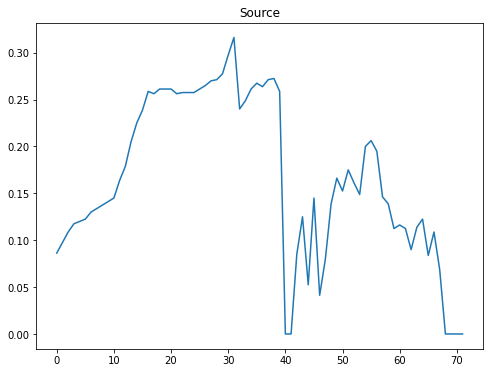

In [20]:
target_dict = sio.loadmat('/content/Target.mat')
target_train_ds, target_test_ds, target_val_ds = gen_dataset_from_dict(target_dict, Val=True)


plt.plot(np.arange(72), source_train_ds.as_numpy_iterator().next()['data'][0, :, 0])
plt.title('Source')
plt.show()

In [21]:
%pip install tensorflow_addons

In [22]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow_addons as tfa


class ResBlock_up_top(tf.keras.layers.Layer):
    def __init__(self, output_channels):
        super().__init__()
        self.bn = layers.BatchNormalization()
        self.unsampling = layers.UpSampling1D()
        self.conv = tfa.layers.SpectralNormalization(layers.Conv1D(filters=output_channels,
                                                                   kernel_size=3,
                                                                   strides=1,
                                                                   padding='same',
                                                                   use_bias=False))
        self.conv_skip = tfa.layers.SpectralNormalization(layers.Conv1D(filters=output_channels,
                                                                        kernel_size=1,
                                                                        strides=1,
                                                                        padding='same',
                                                                        use_bias=False))
        self.relu = layers.LeakyReLU()
        self.dropout = layers.Dropout(0.3)

    def __call__(self, inputs):
        res = inputs
        res = self.unsampling(res)
        res = self.conv_skip(res)

        x = self.bn(inputs)
        x = self.relu(x)
        x = self.unsampling(x)
        x = self.conv_skip(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.dropout(x)

        return x + res


class ResBlock(tf.keras.layers.Layer):
    def __init__(self, output_channels):
        super().__init__()
        self.Conv = tfa.layers.SpectralNormalization(layers.Conv1D(filters=output_channels,
                                                                   kernel_size=3,
                                                                   strides=1,
                                                                   padding='same',
                                                                   use_bias=False))
        self.Relu = layers.LeakyReLU()
        self.dropout = layers.Dropout(0.2)

    def __call__(self, inputs):
        res = inputs
        x = self.Conv(inputs)
        x = self.dropout(x)
        x = self.Relu(x)
        x = self.Conv(x)
        x = self.dropout(x)
        x = x + res
        return x


class ResBlock_up(tf.keras.layers.Layer):
    def __init__(self, output_channels, **kwargs):
        super().__init__(**kwargs)
        self.bn = layers.BatchNormalization()
        self.dropout = layers.Dropout(0.2)
        self.relu = layers.LeakyReLU()
        self.unsampling = layers.UpSampling1D()
        self.conv = tfa.layers.SpectralNormalization(layers.Conv1D(filters=output_channels,
                                                                   kernel_size=3,
                                                                   strides=1,
                                                                   padding='same',
                                                                   use_bias=False))
        self.conv_skip = tfa.layers.SpectralNormalization(layers.Conv1D(filters=output_channels,
                                                                        kernel_size=1,
                                                                        padding='same',
                                                                        use_bias=False))

    def __call__(self, inputs):
        res = inputs
        res = self.unsampling(res)
        res = self.conv_skip(res)
        x = self.bn(inputs)
        x = self.relu(x)
        x = self.unsampling(x)
        x = self.conv_skip(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.dropout(x)
        return x + res


class ResBlock_Down(tf.keras.layers.Layer):
    def __init__(self, output_channels):
        super().__init__()
        self.relu = layers.LeakyReLU()
        self.conv = tfa.layers.SpectralNormalization(layers.Conv1D(filters=output_channels,
                                                                   kernel_size=3,
                                                                   padding='same',
                                                                   use_bias=False))
        self.conv_skip = tfa.layers.SpectralNormalization(layers.Conv1D(filters=output_channels,
                                                                        kernel_size=1,
                                                                        padding='same',
                                                                        use_bias=False))
        self.avg_pooling = layers.AveragePooling1D(padding='same')
        self.dropout = layers.Dropout(0.2)

    def __call__(self, inputs):
        res = self.conv_skip(inputs)
        res = self.avg_pooling(res)

        x = self.relu(inputs)
        x = self.conv_skip(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.dropout(x)
        x = self.avg_pooling(x)

        return x + res


class Res_Dense(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.dense = tfa.layers.SpectralNormalization(layers.Dense(units))
        self.drop = layers.Dropout(0.3)
        self.relu = layers.LeakyReLU()

    def __call__(self, inputs):
        res = inputs
        res = self.dense(res)
        res = self.relu(res)

        x = self.dense(inputs)
        x = self.drop(x)
        x = self.relu(x)

        return x + res


class bottle_neck(tf.keras.layers.Layer):
    def __init__(self, output_channels):
        super().__init__()
        self.filters = output_channels
        self.bn = layers.BatchNormalization()
        self.conv = layers.Conv1D(filters=output_channels,
                                  kernel_size=3,
                                  padding='same',
                                  use_bias=False)
        self.conv_skip = layers.Conv1D(filters=output_channels,
                                       kernel_size=1,
                                       strides=1,
                                       padding='same',
                                       use_bias=False)
        self.conv_trans = layers.Conv1D(filters=output_channels,
                                                 kernel_size=1,
                                                 strides=1,
                                                 padding='same',
                                                 use_bias=False)
        self.unsampling = layers.UpSampling1D()
        self.relu = layers.LeakyReLU()

    def __call__(self, inputs):
        if self.filters != inputs.get_shape().as_list()[-1]:
            res = self.conv_skip(inputs)
        else:
            res = inputs
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv_trans(x)
        x = self.bn(x)
        x = self.relu(x)
        z = x + res

        return x + res


class bottleneck_rev_s(layers.Layer):
    def __init__(self, channels):
        super().__init__()
        self.filters = channels
        self.unit = bottle_neck(int(channels//2.0))
        self.dense = layers.Dense(int(channels//2.0))

    def __call__(self, inputs):
        x1, x2 = tf.split(inputs, 2, 2)
        if self.filters != inputs.get_shape().as_list()[-1]:
            x1 = self.dense(x1)
        y1 = x1 + self.unit(x2)
        y2 = x2
        z = tf.concat([y2, y1], axis=2)
        return z


class ResBlock_no_sn(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.dense1 = layers.Dense(units)
        self.dense2 = layers.Dense(units)
        self.dropout = layers.Dropout(0.3)
        self.relu = layers.LeakyReLU()

    def __call__(self, inputs):
        res = self.dense1(inputs)
        res = self.relu(res)

        x = self.dense1(inputs)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.dropout(x)
        x = self.relu(x)
        return x+res


In [23]:
import time
from IPython import display
import tensorflow_addons as tfa


BANDS = 72
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(72, 1)))
    model.add(ResBlock_up_top(72))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv1D(
        filters=72,
        kernel_size=3,
        padding='same',
        use_bias=False
    ))
    model.add(tf.keras.layers.Reshape(target_shape=(72, 144)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(72, use_bias=True))
    model.add(tf.keras.layers.Dense(1, use_bias=False))
    model.build()
    return model


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(72, 1)))
    model.add(ResBlock_Down(72))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(Res_Dense(1))
    return model


def make_discriminator_domain_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(FEATURE_dim, 1)))
    model.add(ResBlock_Down(72))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(Res_Dense(1))
    return model


def make_classifier_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(FEATURE_dim*2, input_shape=(36, 1)))
    model.add(ResBlock_up_top(FEATURE_dim))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(ResBlock_up(FEATURE_dim))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(CLASSES_NUM, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Flatten())
    model.add(layers.Dense(CLASSES_NUM))
    return model


def make_encoder_model():
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(72, 1)))
    model.add(layers.Conv1D(filters=72,
                            kernel_size=7,
                            strides=1,
                            padding='same',
                            use_bias=False))
    model.add(layers.MaxPool1D())
    model.add(bottleneck_rev_s(36))
    model.add(layers.Dropout(0.3))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1))
    return model


# define losses
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cat_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = binary_cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = binary_cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return binary_cross_entropy(tf.ones_like(fake_output), fake_output)


def classifier_loss(prediction, label):
    return cat_cross_entropy(label, prediction)


generator_s_optimizer = tf.keras.optimizers.Adagrad(lr)
generator_t_optimizer = tf.keras.optimizers.Adagrad(lr)
discriminator_t_optimizer = tf.keras.optimizers.Adagrad(lr)
discriminator_s_optimizer = tf.keras.optimizers.Adagrad(lr)
discriminator_domain_optimizer = tf.keras.optimizers.Adagrad(lr)
encoder_s_optimizer = tf.keras.optimizers.Adagrad(lr)
encoder_t_optimizer = tf.keras.optimizers.Adagrad(lr)
classifier_optimizer = tf.keras.optimizers.Adagrad(lr)


In [24]:
import tensorflow as tf
import datetime
import numpy as np


test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
domain_source_loss = tf.keras.metrics.Mean('domain_source_loss', dtype=tf.float32)
domain_target_loss = tf.keras.metrics.Mean('domain_target_loss', dtype=tf.float32)
gen_loss = tf.keras.metrics.Mean('generator_source_loss', dtype=tf.float32)
disc_loss = tf.keras.metrics.Mean('discriminator_t_loss', dtype=tf.float32)
source_test_accuracy = tf.keras.metrics.CategoricalAccuracy('source_test_accuracy')
target_test_accuracy = tf.keras.metrics.CategoricalAccuracy('target_test_accuracy')
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
test_summary_writer = tf.summary.create_file_writer(test_log_dir)


def test_step1(encoder_s, encoder_t, classifier, source_batch, target_batch):
    Xs, Ys = get_data_from_batch(source_batch)
    Xt, Yt = get_data_from_batch(target_batch)
    feature_s = encoder_s(Xs, training=False)
    feature_t = encoder_t(Xt, training=False)
    prediction_s = classifier(feature_s, training=False)
    prediction_t = classifier(feature_t, training=False)
    loss = (classifier_loss(prediction_s, Ys).numpy() + classifier_loss(prediction_t, Yt).numpy()) / 2
    test_loss(loss)
    source_test_accuracy(Ys, prediction_s)
    target_test_accuracy(Yt, prediction_t)


def test_step2(encoder_s, encoder_t, discriminator_domain,
               source_batch, target_batch):
    Xs, Ys = get_data_from_batch(source_batch)
    Xt, Yt = get_data_from_batch(target_batch)
    feature_s = encoder_s(Xs, training=False)
    feature_t = encoder_t(Xt, training=False)
    source_decision = discriminator_domain(feature_s, training=False)
    target_decision = discriminator_domain(feature_t, training=False)
    domain_source_loss(discriminator_loss(source_decision, target_decision).numpy())
    domain_target_loss(discriminator_loss(target_decision, source_decision).numpy())


def test_step3(generator_s, generator_t, discriminator_t, discriminator_s,
               source_batch, target_batch):
    Xs, Ys = get_data_from_batch(source_batch)
    Xt, Yt = get_data_from_batch(target_batch)
    generated_t = generator_s(Xs, training=False)
    real_target_output = discriminator_t(Xt, training=False)
    fake_target_output = discriminator_t(generated_t, training=False)
    gen_s_loss = generator_loss(fake_target_output)
    disc_t_loss = discriminator_loss(real_target_output, fake_target_output)

    gen_loss(gen_s_loss)
    disc_loss(disc_t_loss)


def test_step4(generator_s, encoder_t, classifier, source_batch):
    Xs, Ys = get_data_from_batch(source_batch)
    generated_t = generator_s(Xs, training=False)
    feature_t = encoder_t(generated_t, training=False)
    prediction = classifier(feature_t, training=False)
    loss = classifier_loss(prediction, Ys)
    test_loss(loss)
    target_test_accuracy(Ys, prediction)

In [25]:
import datetime

import scipy.io as sio
import os
generator_train_loss = tf.keras.metrics.Mean('generator_loss', dtype=tf.float32)
discriminator_train_loss = tf.keras.metrics.Mean('discriminator_loss', dtype=tf.float32)
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
source_train_accuracy = tf.keras.metrics.CategoricalAccuracy('source_train_accuracy')
target_train_accuracy = tf.keras.metrics.CategoricalAccuracy('target_train_accuracy')
train_summary_writer = tf.summary.create_file_writer(train_log_dir)


@tf.function
def train_step_encoder(encoder_s,
                       encoder_t,
                       classifier,
                       source_batch,
                       target_batch,
                       epoch):
    """encode the real samples,
       make predictions of features,
       =========BLOCK 1=========="""
    # print(epoch)
    source_data, source_label = get_data_from_batch(source_batch)
    target_data, target_label = get_data_from_batch(target_batch)
    with tf.GradientTape(persistent=True) as tape:
        source_feature = encoder_s(source_data, training=True)
        target_feature = encoder_t(target_data, training=True)

        classify_source = classifier(source_feature, training=True)
        # print('source_decision', classify_source[0][:])
        classify_loss = classifier_loss(classify_source, source_label)
        encoder_s_loss = classifier_loss(classify_source, source_label)

        classify_target = classifier(target_feature, training=True)
        classify_loss += classifier_loss(classify_target, target_label)
        encoder_t_loss = classifier_loss(classify_target, target_label)

        gradient_source = tape.gradient(encoder_s_loss,
                                        encoder_s.trainable_variables)
        gradient_target = tape.gradient(encoder_t_loss,
                                        encoder_t.trainable_variables)
        gradient_classifier = tape.gradient(classify_loss,
                                            classifier.trainable_variables)
        encoder_s_optimizer.apply_gradients(zip(gradient_source,
                                                encoder_s.trainable_variables))
        encoder_t_optimizer.apply_gradients(zip(gradient_target,
                                                encoder_t.trainable_variables))
        classifier_optimizer.apply_gradients(zip(gradient_classifier,
                                                 classifier.trainable_variables))
    train_loss(classify_loss)
    source_train_accuracy(source_label, classify_source)
    target_train_accuracy(target_label, classify_target)
    del tape


@tf.function
def train_step_domain(encoder_s,
                      encoder_t,
                      classifier,
                      discriminator_domain,
                      source_batch,
                      target_batch):
    """encode the real samples,
       discriminate domain,
       =========BLOCK 2=========="""
    source_data, source_label = get_data_from_batch(source_batch)
    target_data, target_label = get_data_from_batch(target_batch)
    with tf.GradientTape(persistent=True) as tape:
        source_feature = encoder_s(source_data, training=True)
        target_feature = encoder_t(target_data, training=True)

        disc_decision_s = discriminator_domain(source_feature, training=True)
        disc_decision_t = discriminator_domain(target_feature, training=True)
        prediction_s = classifier(source_feature, training=True)
        prediction_t = classifier(target_feature, training=True)

        """if decision>0.5, then see it as source
            otherwise see it as target,
            0.5 means the discriminator cannot discriminate domains"""
        encoder_s_loss = binary_cross_entropy(tf.zeros_like(disc_decision_s), disc_decision_s)
        encoder_s_loss += classifier_loss(prediction_s, source_label)
        encoder_t_loss = binary_cross_entropy(tf.ones_like(disc_decision_t), disc_decision_t)
        encoder_t_loss += classifier_loss(prediction_t, target_label)
        disc_domain_loss = discriminator_loss(disc_decision_s, disc_decision_t)

        encoder_s_gradient = tape.gradient(encoder_s_loss, encoder_s.trainable_variables)
        encoder_t_gradient = tape.gradient(encoder_t_loss, encoder_t.trainable_variables)
        discriminator_domain_gradient = tape.gradient(disc_domain_loss, discriminator_domain.trainable_variables)

        encoder_s_optimizer.apply_gradients(zip(encoder_s_gradient, encoder_s.trainable_variables))
        encoder_t_optimizer.apply_gradients(zip(encoder_t_gradient, encoder_s.trainable_variables))
        discriminator_domain_optimizer.apply_gradients(zip(discriminator_domain_gradient,
                                                           discriminator_domain.trainable_variables))
    train_loss(disc_domain_loss)
    del tape


@tf.function
def train_step_double_GAN(generator_s, generator_t,
                          discriminator_t, discriminator_s,
                          batch_source, batch_target):
    """GAN block, generate target from source,
       generate source from target
       =========BLOCK 3=========="""
    data_source, label_source = get_data_from_batch(batch_source)
    data_target, label_target = get_data_from_batch(batch_target)
    with tf.GradientTape(persistent=True) as tape:
        generated_t = generator_s(data_source, training=True)
        generated_s = generator_t(data_target, training=True)
        fake_decision_t = discriminator_t(generated_t)
        real_decision_t = discriminator_t(data_target)
        fake_decision_s = discriminator_s(generated_s)
        real_decision_s = discriminator_s(data_source)

        gen_s_loss = generator_loss(fake_decision_t)
        disc_t_loss = discriminator_loss(real_decision_t, fake_decision_t)
        gen_t_loss = generator_loss(fake_decision_s)
        disc_s_loss = discriminator_loss(real_decision_s, fake_decision_s)

        gradient_gen_s = tape.gradient(gen_s_loss, generator_s.trainable_variables)
        gradient_gen_t = tape.gradient(gen_t_loss, generator_t.trainable_variables)
        gradient_disc_t = tape.gradient(disc_t_loss, discriminator_t.trainable_variables)
        gradient_disc_s = tape.gradient(disc_s_loss, discriminator_s.trainable_variables)

        generator_s_optimizer.apply_gradients(zip(gradient_gen_s, generator_s.trainable_variables))
        generator_t_optimizer.apply_gradients(zip(gradient_gen_t, generator_t.trainable_variables))
        discriminator_t_optimizer.apply_gradients(zip(gradient_disc_t, discriminator_t.trainable_variables))
        discriminator_s_optimizer.apply_gradients(zip(gradient_disc_s, discriminator_s.trainable_variables))
    generator_train_loss(gen_s_loss)
    discriminator_train_loss(disc_t_loss)
    del tape


@tf.function
def train_step_whole(generator_s, generator_t,
                     discriminator_t, discriminator_s,
                     discriminator_domain,
                     encoder_s, encoder_t,
                     classifier,
                     source_batch, target_batch
                     ):
    """The whole training procedure,
       including GAN_st, GAN_domain,
          encode and classify
       =========BLOCK 4=========="""
    data_source, label_source = get_data_from_batch(source_batch)
    data_target, label_target = get_data_from_batch(target_batch)
    with tf.GradientTape(persistent=True) as tape:
        # GAN source->target
        generated_target = generator_s(data_source, training=True)
        real_decision = discriminator_t(data_target, training=True)
        fake_decision = discriminator_t(generated_target, training=True)
        gen_s_loss = generator_loss(fake_decision)
        disc_t_loss = discriminator_loss(real_decision, fake_decision)
        gen_s_gradient = tape.gradient(gen_s_loss, generator_s.trainable_variables)
        disc_t_gradient = tape.gradient(disc_t_loss, discriminator_t.trainable_variables)
        generator_s_optimizer.apply_gradients(zip(gen_s_gradient, generator_s.trainable_variables))
        discriminator_t_optimizer.apply_gradients(zip(disc_t_gradient, discriminator_t.trainable_variables))

        # GAN target->source
        generated_source = generator_t(data_target, training=True)
        real_decision2 = discriminator_s(data_source, training=True)
        fake_decision2 = discriminator_s(generated_source, training=True)
        gen_t_loss = generator_loss(fake_decision2)
        disc_s_loss = discriminator_loss(real_decision2, fake_decision2)
        gen_t_gradient = tape.gradient(gen_t_loss, generator_t.trainable_variables)
        disc_s_gradient = tape.gradient(disc_s_loss, discriminator_s.trainable_variables)
        generator_t_optimizer.apply_gradients(zip(gen_t_gradient, generator_t.trainable_variables))
        discriminator_s_optimizer.apply_gradients(zip(disc_s_gradient, discriminator_s.trainable_variables))

        # GAN domain
        feature_s = encoder_s(generated_source, training=True)
        feature_t = encoder_t(generated_target, training=True)
        feature_t_real = encoder_t(data_target, training=True)
        target_decision = discriminator_domain(feature_t, training=True)
        source_decision = discriminator_domain(feature_s, training=True)
        disc_domain_loss = discriminator_loss(source_decision, target_decision)
        encoder_s_loss = binary_cross_entropy(tf.zeros_like(source_decision), source_decision)
        encoder_t_loss = binary_cross_entropy(tf.ones_like(target_decision), target_decision)
        # calculate the gradient of encoders later, since it need to be combined with classification loss
        disc_domain_gradient = tape.gradient(disc_domain_loss, discriminator_domain.trainable_variables)
        discriminator_domain_optimizer.apply_gradients(zip(disc_domain_gradient,
                                                           discriminator_domain.trainable_variables))
        # classify
        prediction_s = classifier(feature_s, training=True)
        prediction_t = classifier(feature_t, training=True)
        prediction_t_real = classifier(feature_t_real, training=True)
        pred_loss = classifier_loss(prediction_t, label_source)
        pred_loss += classifier_loss(prediction_t_real, label_target)
        encoder_s_loss += classifier_loss(prediction_s, label_target)
        encoder_t_loss += classifier_loss(prediction_t, label_source)
        encoder_s_gradient = tape.gradient(encoder_s_loss, encoder_s.trainable_variables)
        encoder_t_gradient = tape.gradient(encoder_t_loss, encoder_t.trainable_variables)
        classifier_gradient = tape.gradient(pred_loss, classifier.trainable_variables)
        encoder_s_optimizer.apply_gradients(zip(encoder_s_gradient, encoder_s.trainable_variables))
        encoder_t_optimizer.apply_gradients(zip(encoder_t_gradient, encoder_t.trainable_variables))
        classifier_optimizer.apply_gradients(zip(classifier_gradient, classifier.trainable_variables))
    train_loss(pred_loss/2)
    target_train_accuracy(label_source, prediction_t)
    del tape


def train(generator_s, generator_t,
          discriminator_t, discriminator_s, discriminator_domain,
          encoder_s, encoder_t, classifier,
          source_train_ds, target_train_ds, source_test_ds, target_test_ds,
          epochs):
    whole_start = time.time()
    # block1: encode and classify
    patience = PATIENCE
    wait = 0
    best = 0
    for epoch in range(100):
        print('=====================- block 1 -========================')
        start = time.time()
        for source_batch in source_train_ds.as_numpy_iterator():
            for target_batch in target_train_ds.as_numpy_iterator():
                train_step_encoder(encoder_s,
                                   encoder_t,
                                   classifier,
                                   source_batch,
                                   target_batch, epoch)
        with train_summary_writer.as_default():
            tf.summary.scalar('block1_train_loss', train_loss.result(), step=epoch)
            tf.summary.scalar('block1_train_acc', target_train_accuracy.result(), step=epoch)
        template = 'Epoch {}: Train loss={:.2f},' \
                   ' source_train_accuracy={:.2f}%,' \
                   ' target_train_accuracy={:.2f}%'
        print(template.format(epoch+1,
                              train_loss.result(),
                              source_train_accuracy.result()*100,
                              target_train_accuracy.result()*100))

        for source_batch in source_test_ds.as_numpy_iterator():
            for target_batch in target_test_ds.as_numpy_iterator():
                test_step1(encoder_s, encoder_t, classifier, source_batch, target_batch)
        template = 'Epoch {}: Test loss={:.2f}, ' \
                   'source_test_accuracy={:.2f}%,' \
                   ' target_test_accuracy={:.2f}%'
        print(template.format(epoch + 1, test_loss.result(),
                              source_test_accuracy.result() * 100,
                              target_test_accuracy.result() * 100))
        with test_summary_writer.as_default():
            tf.summary.scalar('block1_test_loss', test_loss.result(), step=epoch)
            tf.summary.scalar('block1_test_target_accuracy', target_test_accuracy.result(), step=epoch)
        test_acc = target_test_accuracy.result().numpy()
        # Reset metrics every epoch
        train_loss.reset_states()
        test_loss.reset_states()
        source_train_accuracy.reset_states()
        target_train_accuracy.reset_states()
        source_test_accuracy.reset_states()
        target_test_accuracy.reset_states()
        print('Time for epoch{} is {:.2f} sec'.format(epoch+1, time.time()-start))
        if epoch > 30:
            wait += 1
            if test_acc > best:
                best = test_acc
                wait = 0
            if wait >= patience:
                break
    print('Saving encoder and classifier...')
    tf.saved_model.save(encoder_s, './Model/block1/encoder_s')
    tf.saved_model.save(encoder_t, './Model/block1/encoder_t')
    tf.saved_model.save(classifier, './Model/block1/classifier')

    # block2: encode, GAN_domain and classify
    for epoch in range(100):
        print('=====================- block 2 -========================')
        start = time.time()
        for source_batch in source_train_ds.as_numpy_iterator():
            for target_batch in target_train_ds.as_numpy_iterator():
                train_step_domain(encoder_s,
                                  encoder_t,
                                  classifier,
                                  discriminator_domain,
                                  source_batch,
                                  target_batch)
        with train_summary_writer.as_default():
            tf.summary.scalar('block2_train_disc_domain_loss', train_loss.result(), step=epoch)
        template = 'Train epoch {}, discriminator_domain_loss={:.2f}'
        print(template.format(epoch+1, train_loss.result().numpy()))
        for source_batch in source_test_ds.as_numpy_iterator():
            for target_batch in target_test_ds.as_numpy_iterator():
                test_step2(encoder_s, encoder_t, discriminator_domain, source_batch, target_batch)
        template = 'Test epoch {}, discriminator_source_loss={:.2f}, discriminator_target_loss={:.2f}'
        print(template.format(epoch+1, domain_source_loss.result().numpy(), domain_target_loss.result().numpy()))
        with test_summary_writer.as_default():
            tf.summary.scalar('block2_test_domain_target_loss', domain_target_loss.result(), step=epoch)
        train_loss.reset_states()
        domain_source_loss.reset_states()
        domain_target_loss.reset_states()
        print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))
    print('Saving encoder, discriminator_domain and classifier...')
    tf.saved_model.save(encoder_s, './Model/block2/encoder_s')
    tf.saved_model.save(encoder_t, './Model/block2/encoder_t')
    tf.saved_model.save(discriminator_domain, './Model/block2/discriminator_domain')
    tf.saved_model.save(classifier, './Model/block2/classifier')

    # block3: GAN_transfer
    for epoch in range(100):
        print('=====================- block 3 -========================')
        start = time.time()
        for source_batch in source_train_ds.as_numpy_iterator():
            for target_batch in target_train_ds.as_numpy_iterator():
                train_step_double_GAN(generator_s,
                                      generator_t,
                                      discriminator_t,
                                      discriminator_s,
                                      source_batch,
                                      target_batch)
        template = 'Train epoch {}, generator_loss={:.2f}, discriminator_loss={:.2f}'
        print(template.format(epoch+1, generator_train_loss.result().numpy(),
                              discriminator_train_loss.result().numpy()))
        with train_summary_writer.as_default():
            tf.summary.scalar('block3_train_gen_loss', generator_train_loss.result(), step=epoch)
            tf.summary.scalar('block3_train_disc_loss', discriminator_train_loss.result(), step=epoch)
        for source_batch in source_test_ds.as_numpy_iterator():
            for target_batch in target_test_ds.as_numpy_iterator():
                test_step3(generator_s, generator_t, discriminator_t, discriminator_s,
                           source_batch, target_batch)
        template = 'Test epoch {}, generator_loss={:.2f}, discriminator_loss={:.2f}'
        print(template.format(epoch+1, gen_loss.result(), disc_loss.result()))
        with test_summary_writer.as_default():
            tf.summary.scalar('block3_test_gen_loss', gen_loss.result(), step=epoch)
            tf.summary.scalar('block3_test_disc_loss', disc_loss.result(), step=epoch)
        if epoch % 15 == 0:
            generate_and_save_Images(generator_s, epoch, source_test_ds.as_numpy_iterator().next()['data'])
        print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))
        generator_train_loss.reset_states()
        discriminator_train_loss.reset_states()
        gen_loss.reset_states()
        disc_loss.reset_states()
    print('Saving generator and discriminator...')
    tf.saved_model.save(generator_s, './Model/block3/generator_s')
    tf.saved_model.save(generator_t, './Model/block3/generator_t')
    tf.saved_model.save(discriminator_t, './Model/block3/discriminator_t')
    tf.saved_model.save(discriminator_s, './Model/block3/discriminator_s')

    # block4 the whole network
    patience = PATIENCE
    wait = 0
    best = 0
    for epoch in range(epochs):
        start = time.time()
        train_acc = 0
        print('=====================- block 4 -========================')
        for source_batch in source_train_ds.as_numpy_iterator():
            for target_batch in target_train_ds.as_numpy_iterator():
                train_step_whole(generator_s, generator_t,
                                 discriminator_t, discriminator_s,
                                 discriminator_domain,
                                 encoder_s, encoder_t,
                                 classifier,
                                 source_batch, target_batch)
        template = 'Train epoch {}, classifier_loss={:.2f}, classifier_accuracy={:.2f}%'
        print(template.format(epoch+1,
                              train_loss.result(),
                              target_train_accuracy.result()*100))
        train_acc = target_train_accuracy.result().numpy()
        with train_summary_writer.as_default():
            tf.summary.scalar('block4_loss', train_loss.result(), step=epoch)
            tf.summary.scalar('block4_acc', target_train_accuracy.result(), step=epoch)
        for source_batch in source_test_ds.as_numpy_iterator():
            test_step4(generator_s, encoder_t, classifier, source_batch)
        template = 'Test epoch {}, classifier_loss={:.2f}, classifier_accuracy={:.2f}%'
        print(template.format(epoch+1,
                              test_loss.result(),
                              target_test_accuracy.result()*100))
        with test_summary_writer.as_default():
            tf.summary.scalar('blcok4_loss', test_loss.result(), step=epoch)
            tf.summary.scalar('block_acc', target_test_accuracy.result(), step=epoch)
        if epoch % 15 == 0:
            generate_and_save_Images(generator_s, epoch, source_test_ds.as_numpy_iterator().next()['data'])
        train_loss.reset_states()
        target_train_accuracy.reset_states()
        test_loss.reset_states()
        target_test_accuracy.reset_states()
        print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))
        if epoch >= 700:
            wait += 1
            if train_acc > best:
                best = train_acc
                wait = 0
            if wait >= patience:
                break
    print('Saving whole network...')
    tf.saved_model.save(generator_s, './Model/block4/generator_s')
    tf.saved_model.save(generator_t, './Model/block4/generator_t')
    tf.saved_model.save(discriminator_t, './Model/block4/discriminator_t')
    tf.saved_model.save(discriminator_s, './Model/block4/discriminator_s')
    tf.saved_model.save(encoder_s, './Model/block4/encoder_s')
    tf.saved_model.save(encoder_t, './Model/block4/encoder_t')
    tf.saved_model.save(discriminator_domain, './Model/block4/discriminator_domain')
    tf.saved_model.save(classifier, './Model/block4/classifier')
    print('The whole procedure takes {} sec'.format(time.time()-whole_start))

In [ ]:
generator_s = make_generator_model()
generator_t = make_generator_model()
discriminator_t = make_discriminator_model()
discriminator_s = make_discriminator_model()
discriminator_domain = make_discriminator_domain_model()
encoder_s = make_encoder_model()
encoder_t = make_encoder_model()
classifier = make_classifier_model()

train(generator_s, generator_t,
      discriminator_t, discriminator_s,
      discriminator_domain,
      encoder_s, encoder_t, classifier,
      source_train_ds, target_train_ds,
      source_test_ds, target_test_ds,
      EPOCHS)


=====================- block 1 -========================


In [ ]:
val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)
val_accuracy = tf.keras.metrics.CategoricalAccuracy('val_accuracy')

for val_batch in target_val_ds.as_numpy_iterator():
    x, y = get_data_from_batch(val_batch)
    x_feature = encoder_t(x, training=False)
    prediction = classifier(x_feature, training=False)
    val_loss(classifier_loss(prediction, y))
    val_accuracy(y, prediction)
    template = 'Loss: {}, Accuracy: {}'
    print(template.format(val_loss.result(),
                          val_accuracy.result() * 100))
